# Development of an Adaptable Deep Learning Model for Artistic Style Transfer

---




In [24]:
# Mounting the drive in google colab
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



The style transfer involves the use of the features contained within a nineteen-layer VGG network that consists of convolutional and some fully connected layers. The figure below labels in the convolutional layers by stack and stack order. The first stack passes an image through Conv_1_1, which is the first convolutional layer. The first convolutional layer in the second stack is known as Conv_2_1. Conv_5_4 is the deepest convolutional layer in the network.

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*PrmF6fhniOOGK8WImxM2KQ.png" width=80% />

### Separating Style and Content

An important aspect of the technology behind style transfer is separating the content and style of the image. Given one content image and one style image, we aim to create a new, _target_ image which should contain our desired content and style components:
* The **content image** shows the object arrangement pattern.
* The **style image** picture shows some characteristics with respect to colors, textures and styles.

An example is shown below, where the content image is of a cat, and the style image is of [Hokusai's Great Wave](https://en.wikipedia.org/wiki/The_Great_Wave_off_Kanagawa). The generated target image still contains the cat but is stylized with the waves, blue and beige colors, and block print textures of the style image!

<img src='https://github.com/udacity/deep-learning-v2-pytorch/raw/master/style-transfer/notebook_ims/style_tx_cat.png' width=80% />

In [1]:
# import resources
%matplotlib inline

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
from torchvision import transforms, models

## Load in VGG19 (features)

VGG19 is split into two portions:
* `vgg19.features`, which are all the convolutional and pooling layers
* `vgg19.classifier`, which are the three linear, classifier layers at the end

We only need the `features` portion, which we're going to load in and "freeze" the weights of, below.

In [2]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True).features

# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 96.3MB/s]


In [3]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

### Loading the Content and Style Images

With this, you will be able to load in any image that you might desire. The following is an example of a helper function that can help when loading any sort or size of image. The `load_image` function also normalize images into Tensors.

Secondly, it will involve having minor pictures and compressing both content and style images to match in terms of sizes.

In [4]:
def load_image(img_path, max_size=400, shape=None):
    ''' Load in and transform an image, making sure the image
       is <= 400 pixels in the x-y dims.'''

    image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape is not None:
        size = shape

    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406),
                                             (0.229, 0.224, 0.225))])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = in_transform(image)[:3,:,:].unsqueeze(0)

    return image

Next, I'm loading in images by file name and forcing the style image to be the same size as the content image.

Download Required Content and Style Images...

In [31]:
!wget https://drive.google.com/file/d/1tR9fc6IwfKp0pPwG1U718mjdnsaNcUxo/view?usp=sharing
!wget https://drive.google.com/file/d/1SdXVdQlXss2i3GixuCkxeTcyo9ZoW-b1/view?usp=sharing

--2023-11-18 08:42:22--  https://drive.google.com/file/d/1tR9fc6IwfKp0pPwG1U718mjdnsaNcUxo/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.251.2.101, 142.251.2.100, 142.251.2.138, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing’

view?usp=sharing        [ <=>                ]  82.33K  --.-KB/s    in 0.004s  

2023-11-18 08:42:22 (18.2 MB/s) - ‘view?usp=sharing’ saved [84301]

--2023-11-18 08:42:22--  https://drive.google.com/file/d/1SdXVdQlXss2i3GixuCkxeTcyo9ZoW-b1/view?usp=sharing
Resolving drive.google.com (drive.google.com)... 142.251.2.101, 142.251.2.100, 142.251.2.138, ...
Connecting to drive.google.com (drive.google.com)|142.251.2.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘view?usp=sharing.1’

view?usp=sharing.1      [ <=>                ]  82.

In [25]:
# load in content and style image
content = load_image('/content/drive/MyDrive/deep learning model for artistic style transffer/Rohit_Virat.jpg').to(device)
# Resize style to match content, makes code easier
style = load_image('/content/drive/MyDrive/deep learning model for artistic style transffer/eyes_art.jpg', shape=content.shape[-2:]).to(device)

In [9]:
# helper function for un-normalizing an image
# and converting it from a Tensor image to a NumPy image for display
def im_convert(tensor):
    """ Display a tensor as an image. """

    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

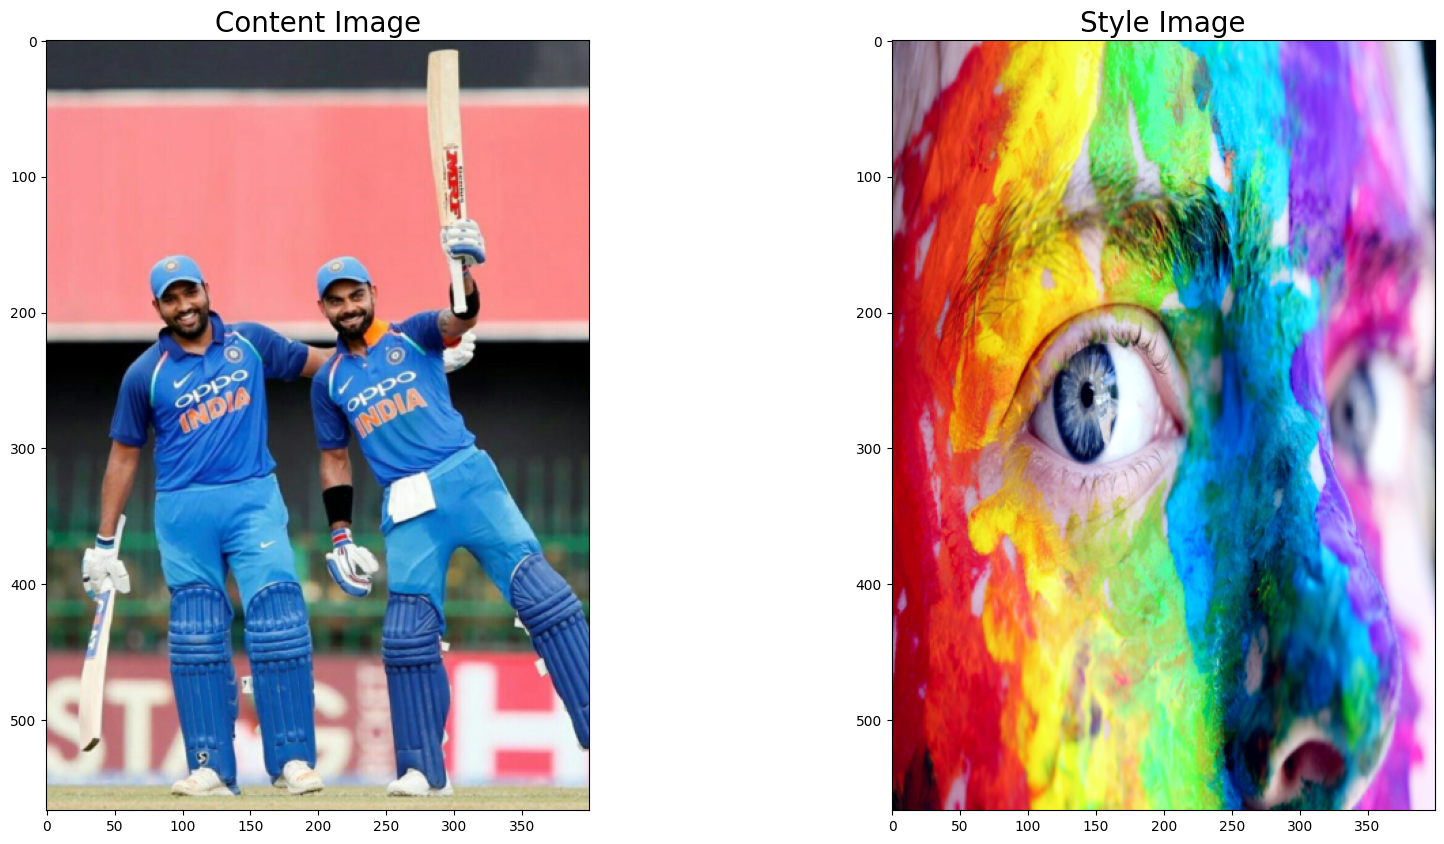

In [26]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(im_convert(content))
ax1.set_title("Content Image",fontsize = 20)
ax2.imshow(im_convert(style))
ax2.set_title("Style Image", fontsize = 20)
plt.show()

---
## VGG19 Layers

In order to obtain the content and the style representations for an image, it is necessary to advance the image through the VGG19 network up until reaching the suitable layers, after which one will retrieve the output from the selected layer(s).

In [12]:
# print out VGG19 structure so you can see the names of various layers
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## Content and Style Features

Below, complete the mapping of layer names to the names found in the paper for the _content representation_ and the _style representation_.

In [13]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for
        a set of layers. Default layers are for VGGNet matching Gatys et al (2016)
    """

    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

---
## Gram Matrix

Each of the convolutional layers produces a Tensor whose size in the number of batches `batch_size` as well as the width and height `h, w`. The Gram matrix of a convolutional layer can be calculated as follows:
* Get the depth, height, and width of a tensor using `batch_size, d, h, w = tensor.size`
* Reshape that tensor so that the spatial dimensions are flattened
* Calculate the gram matrix by multiplying the reshaped tensor by it's transpose

*Note: You can multiply two matrices using `torch.mm(matrix1, matrix2)`.*

In [14]:
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor
        Gram Matrix: https://en.wikipedia.org/wiki/Gramian_matrix
    """

    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)

    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

## Putting it all Together

Having now, wrote functions for extracting features from a specific convolutional layer as well as compute its gram matrix; let’s stick it together!qpoint Once we derive our features from the images, compute the gram matrices for each layer of a stylized representation.

In [27]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

# create a third "target" image and prep it for change
# it is a good idea to start of with the target as a copy of our *content* image
# then iteratively change its style
target = content.clone().requires_grad_(True).to(device)

---
## Loss and Weights

#### Individual Layer Style Weights

In this regard, below is where you get to specify a score for the style weighting at every level that is pertinent. These layers should be weighted on a scale of 0 – 1. To obtain larger style artifacts in your resulting image, use a higher weight on earlier layers (`conv1_1` and `conv2_1`). Weighting of later layers will provide more focus on small features. Each layer can be of varying size, making them unique in their own way. These together form a multi-style pattern representation!

#### Content and Style Weight

We define an alpha (`content_weight`) and a beta (`style_weight`). This ratio will affect how _stylized_ your final image is. It's recommended that you leave the content_weight = 1 and set the style_weight to achieve the ratio you want.

In [28]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

content_weight = 1  # alpha
style_weight = 1e9  # beta

## Updating the Target & Calculating Losses


This is similar to the training loop that you’ve experienced so far—we’re going to modify our _target_ image and nothing else about VGG19 or any other image. # Thus, the number steps are merely what you set yourself. However, depending on different factors such as experimentation of images as well as trial run of weight values, a **user should at least be able to set as few as 2000 steps**.

Within this iteration loop, you will compute the content loss and the style loss before updating your reference image.

#### Content Loss

The content loss will be the mean squared difference between the target and content features at layer `conv4_2`. This can be calculated as follows:
```
content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
```

#### Style Loss

In a similar fashion, we calculate the style loss across a certain number of layers, which are identified as `style_weights` in our dictionary.
> At each of these layers you will calculate the gram matrix for the target image `target_gram`, style image `style_gram` and compare those gram matrices to calculate `layer_style_loss`.
> Then, it will be noted that in this case, this value is normalized by the size of the layer.

#### Total Loss

Finally, you'll create the total loss by adding up the style and content losses and weighting them with your specified alpha and beta!

Intermittently, we'll print out this loss; don't be alarmed if the loss is very large. It takes some time for an image's style to change and you should focus on the appearance of your target image rather than any loss value. Still, you should see that this loss decreases over some number of iterations.

Total loss:  38879817728.0


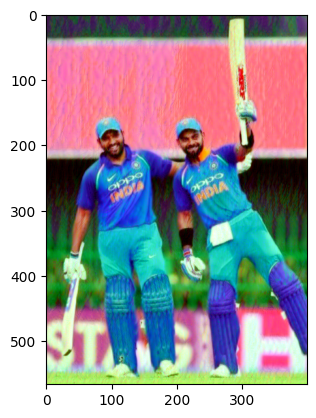

Total loss:  15706038272.0


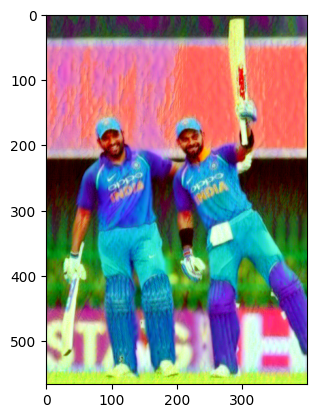

Total loss:  7070212096.0


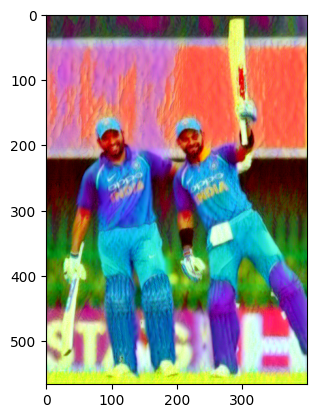

Total loss:  3910912000.0


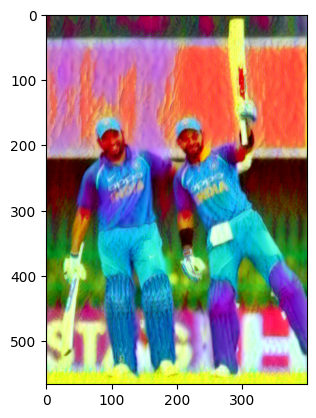

Total loss:  2471524352.0


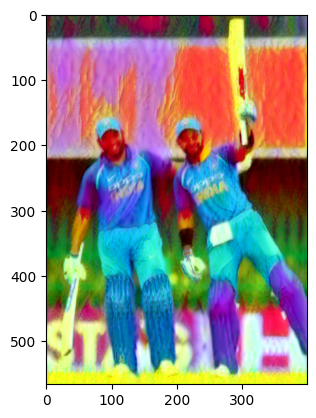

In [29]:
# for displaying the target image, intermittently
show_every = 400

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
steps = 2000  # decide how many iterations to update your image (5000)

for ii in range(1, steps+1):

    # get the features from your target image
    target_features = get_features(target, vgg)

    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)

    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss

    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()

    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(im_convert(target))
        plt.show()

## Display the Target Image

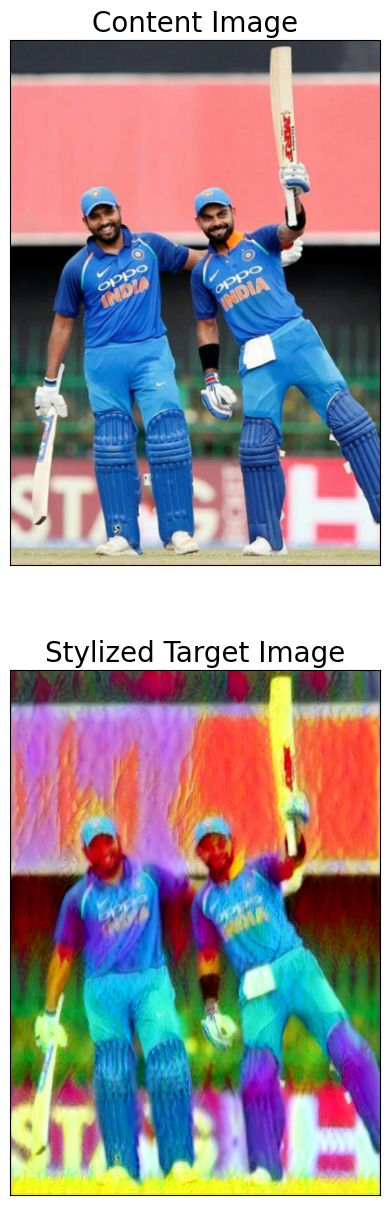

In [30]:
# display content and final, target image
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
ax1.imshow(im_convert(content))
ax1.set_title("Content Image", fontsize = 20)
ax2.imshow(im_convert(target))
ax2.set_title("Stylized Target Image", fontsize = 20)
ax1.grid(False)
ax2.grid(False)
# Hide axes ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
plt.show()